In [1]:
import datetime
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.scale import LogScale
import numpy as np
from os import path
import pandas as pd 
from typing import List

import ruptures as rpt


In [2]:
def df_of_daily_count(csv_file, sep = ','):
    column_names = ["Date", "Count"]
    return pd.read_csv(csv_file, sep=sep, names=column_names, index_col="Date")

def line_graph_of_daily_count(df, title):
    df.plot.line(
        title="BLM tweets " + title,
        figsize = (15,6),
        logy = True,
        )

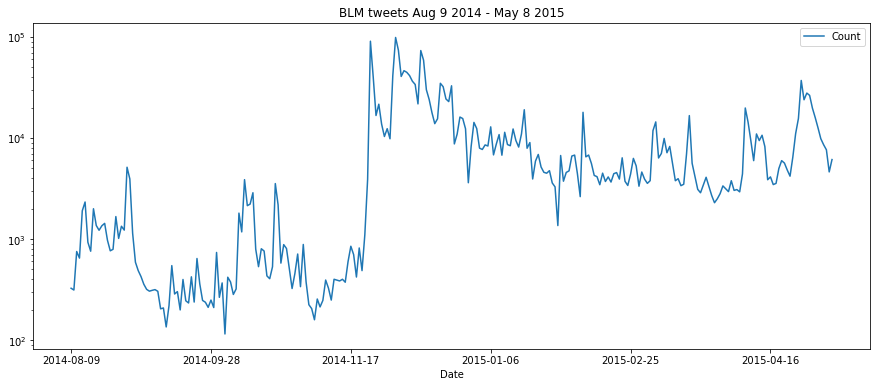

In [3]:
first_counts_file = "../data/counts/tweetCount2014-2015.csv"
first_sep = ','
df_first_counts = df_of_daily_count(first_counts_file, sep=first_sep)
line_graph_of_daily_count(df_first_counts, "Aug 9 2014 - May 8 2015")


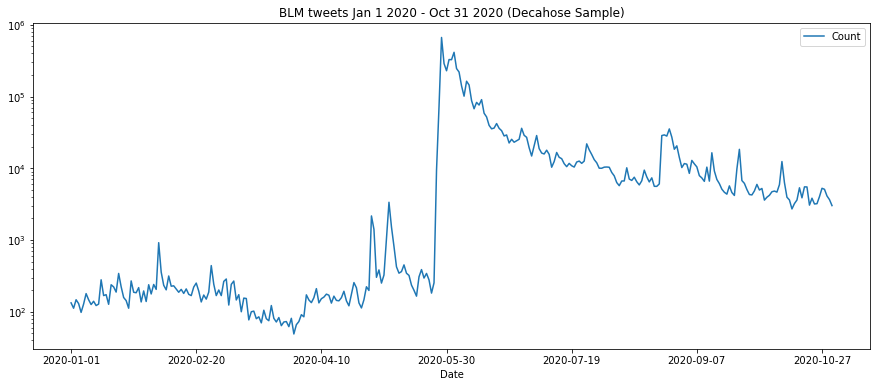

In [4]:
second_counts_file = "../data/counts/tweetCount2020.txt"
second_sep = '\t'
df_second_counts = df_of_daily_count(second_counts_file, sep=second_sep)
line_graph_of_daily_count(df_second_counts, "Jan 1 2020 - Oct 31 2020 (Decahose Sample)")

In [6]:
df_second_counts.head()


,Count
Date,
2020-01-01,133
2020-01-02,112
2020-01-03,147
2020-01-04,130
2020-01-05,98


In [7]:
n_bkps = 2
loss = 'l2'

algo_2014 = rpt.BottomUp(model=loss).fit(df_first_counts.Count.values)
bkps_2014 = algo_2014.predict(n_bkps=n_bkps)
print("2014-2015 boundaries on days:", bkps_2014)


2014-2015 boundaries on days: [105, 140, 273]


In [8]:
algo_2020 = rpt.BottomUp(model=loss).fit(df_second_counts.Count.values)
bkps_2020 = algo_2020.predict(n_bkps=n_bkps)
print("2020 boundaries on days:", bkps_2020)

2020 boundaries on days: [145, 165, 305]


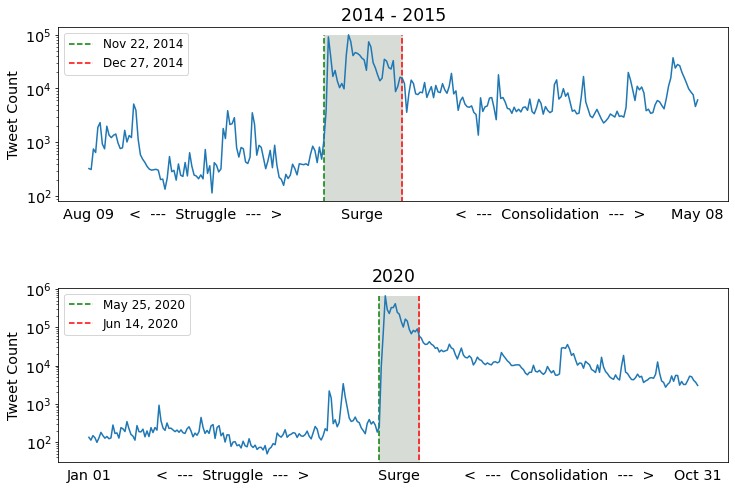

In [67]:
def get_month_day(date_str):
    # assumes string input in format yyyy-mm-dd
    d = datetime.date.fromisoformat(date_str)
    return d.strftime("%b %d")


def formatted_date(iso_date_str):
    d = datetime.date.fromisoformat(iso_date_str)
    return d.strftime("%b %d, %Y")


def display_counts_with_bkps(df, bkps, title, ax: matplotlib.axes.Axes):
    max_count = max(df.Count)
    struggle_pos = int(bkps[0]/2)
    surge_pos = int(0.5 * (bkps[0] + bkps[1]))
    consolidation_pos = int(0.5 * (bkps[1] + len(df)))
    ax.set_xticks([0, struggle_pos, surge_pos,consolidation_pos, len(df) - 1])
    xlabels = [get_month_day(df.index[0])]
    xlabels.extend(['<  ---  Struggle  ---  >', 'Surge', '<  ---  Consolidation  ---  >'])
    xlabels.append(get_month_day(df.index[-1]))
    ax.set_xticklabels(xlabels)
    ax.tick_params(axis='x', labelsize='x-large', width=0)
#    ax.set_xlabel('Phase', fontsize='x-large')
    ax.set_yscale('log')
    ax.tick_params(axis='y', labelsize='x-large')
    ax.set_ylabel("Tweet Count", fontsize='x-large')
    ax.fill_between(bkps[:2], max_count, color="xkcd:light grey")
    ax.plot(df.index, df.Count)
    ax.vlines(bkps[0], 0, max_count, linestyles='dashed', colors=['green'], label=formatted_date(df.index[bkps[0]]))
    ax.vlines(bkps[1], 0, max_count, linestyles='dashed', colors=['red'], label=formatted_date(df.index[bkps[1]]))
    ax.legend(loc="upper left", fontsize='large')
    ax.set_title(title, fontsize='xx-large')

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12,8))
fig.subplots_adjust(hspace=0.5)
display_counts_with_bkps(df_first_counts, bkps_2014, "2014 - 2015", axes[0])
display_counts_with_bkps(df_second_counts, bkps_2020, "2020", axes[1])

In [8]:
def print_changepoint_days(df, bkps, title):
    print("Change point dates during period " + title)
    print(df.index[bkps[0]])
    print(df.index[bkps[1]])
    print()

print_changepoint_days(df_first_counts, bkps_2014, "Aug 9 2014 - May 8 2015")
print_changepoint_days(df_second_counts, bkps_2020, "Jan 1 2020 - Oct 31 2020")

Change point dates during period Aug 9 2014 - May 8 2015
2014-11-22
2014-12-27

Change point dates during period Jan 1 2020 - Oct 31 2020
2020-05-25
2020-06-14



In [5]:
csv_dir = "../data/counts/"

ALM_file = "#AllLivesMatter.csv"
BlueLives_file = "#BlueLivesMatter.csv"
BLM_file = "#BLM.csv"
BlackLives_file = "#BlackLivesMatter.csv"

def get_tag_tweets(file_name: str):
    """Returns DataFrame of avg_tweets binned by month"""
    filepath = path.join(csv_dir, file_name)
    df = pd.read_csv(
        filepath, 
        names=["Date", "Num_Tweets", "Num_Retweets"],
        dtype={"Date": str},
        header=0,
    ).fillna(0)
    df.Num_Tweets = df.Num_Tweets.astype(int)
    df.Num_Retweets = df.Num_Retweets.astype(int)
    df["All_Tweets"] = df.Num_Tweets + df.Num_Retweets
    df = df.drop(["Num_Tweets", "Num_Retweets"], axis=1)
    df.Date = df.Date.apply(lambda x: x[:7])
    return df.groupby("Date").sum()

def get_movement_tweets(file_names: List[str], movement: str):
    dfs: List[pd.DataFrame] = []
    for file_name in file_names:
        dfs.append(get_tag_tweets(file_name))
    dfs[0].All_Tweets += dfs[1].All_Tweets
    return dfs[0].rename(columns={"All_Tweets": movement})

counter_df = get_movement_tweets([ALM_file, BlueLives_file], "Counter-Protest")
activist_df = get_movement_tweets([BLM_file, BlackLives_file], "Activist")

In [6]:
df = activist_df.rename(columns={"Activist": "#BlackLivesMatter, #BLM"})
df["#AllLivesMatter, #BlueLivesMatter"] = counter_df["Counter-Protest"]

In [7]:
df["Ratio"] = np.log(df[df.columns[0]]/df[df.columns[1]])

Text(0.38, 0.75, '(Linear scale)')

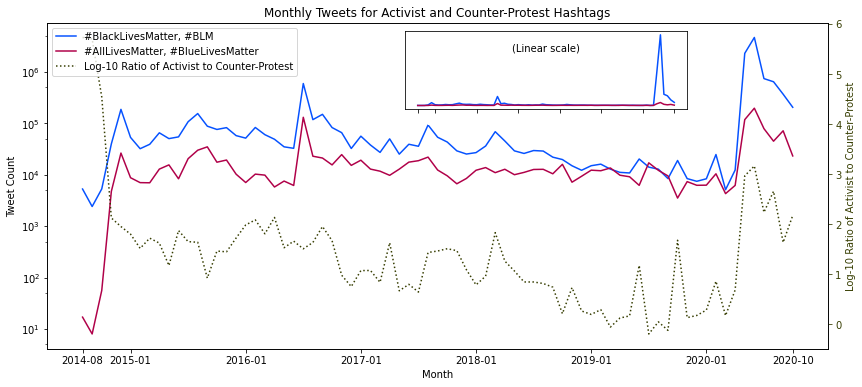

In [37]:
fig, (ax) = plt.subplots(nrows=1, ncols=1, figsize=(14,6))
# plt.xlabel("Month")
# plt.yscale("log", subsy=[5])
# plt.ylabel("Tweet Count")
# plt.title("Monthly Tweets for Activist and Counter-Protest Hashtags")

activist_color, counter_color = "xkcd:electric blue", "xkcd:raspberry"

ax.set_xlabel("Month")
ax.set_yscale("log", subsy=[5])
ax.set_ylabel("Tweet Count")
ax.set_title("Monthly Tweets for Activist and Counter-Protest Hashtags")

plot_handles = []
for column, color in zip(df.columns[:2], [activist_color, counter_color]):
    h, = ax.plot(df.index, df[column], label = column, color=color)
    plot_handles.append(h)

# plot the log ratio
ratio_color = "xkcd:hunter green"
ratio_label = "Log-10 Ratio of Activist to Counter-Protest"
ax2 = ax.twinx()
h, = ax2.plot(df.index, df["Ratio"], label = ratio_label, color=ratio_color, linestyle="dotted")
plot_handles.append(h)
ax2.set_yscale("linear")
ax2.set_ylabel(ratio_label, color=ratio_color)
ax2.tick_params("y", colors=ratio_color)

ticks = [0, 5, 17, 29, 41, 53, 65, 74]
plt.xticks(ticks, df.index[ticks])

legend = plt.legend(handles=plot_handles, loc="upper left")

# Add an inset with linear scale instead of logarithmic
left, bottom, width, height = 0.48, 0.68, 0.28, 0.18
ax_inset = fig.add_axes([left, bottom, width, height])
ax_inset.set_yscale("linear")
for column, color in zip(df.columns[:2], [activist_color, counter_color]):
    h, = ax_inset.plot(df.index, df[column], label = column, color=color)
ax_inset.set_xticks(ticks)
ax_inset.tick_params("x", labelcolor="white")
ax_inset.set_yticks([])
ax_inset.text(0.38, 0.75, "(Linear scale)", transform=ax_inset.transAxes)

In [23]:
ax_inset = fig.add_axes([left, bottom, width, height])
print(ax_inset)

Axes(0.52,0.8;0.3x0.18)


<ipython-input-23-7d79efb2edcf>:1: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax_inset = fig.add_axes([left, bottom, width, height])
